In [109]:
#from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
from scipy.integrate import trapz
%matplotlib nbagg
%load_ext autoreload

plt.rcParams['nbagg.transparent'] = False
plt.rcParams['figure.facecolor'] = 'w'

prop_cycle = plt.rcParams['axes.prop_cycle']
plot_colors = prop_cycle.by_key()['color']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
def roc(pr, Yt, true_class=0):
    """
    Produce the false positive rate and true positive rate required to plot
    a ROC curve, and the area under that curve.
    Parameters
    ----------
    pr : array
        An array of probability scores, either a 1d array of size N_samples or an nd array,
	in which case the column corresponding to the true class will be used.
    Yt : array
        An array of class labels, of size (N_samples,)
    true_class : int
        which class is taken to be the "true class" (e.g. Ia vs everything else)
    Returns
    -------
    fpr : array
        An array containing the false positive rate at each probability threshold
    tpr : array
        An array containing the true positive rate at each probability threshold
    auc : float
        The area under the ROC curve
    """
    probs = pr.copy()
    Y_test = Yt.copy()
    min_class = (int)(Y_test.min())  # This is to deal with starting class assignment at 1.
    Y_test = Y_test.squeeze()
    
    if len(pr.shape)>1:
        probs_1 = probs[:, true_class-min_class]
    else:
        probs_1 = probs
    
    threshold = np.linspace(0., 1., 50)  # 50 evenly spaced numbers between 0,1

    # This creates an array where each column is the prediction for each threshold
    preds = np.tile(probs_1, (len(threshold), 1)).T >= np.tile(threshold, (len(probs_1), 1))
    Y_bool = (Y_test == true_class)
    Y_bool = np.tile(Y_bool, (len(threshold), 1)).T
    
    TP = (preds & Y_bool).sum(axis=0)
    FP = (preds & ~Y_bool).sum(axis=0)
    TN = (~preds & ~Y_bool).sum(axis=0)
    FN = (~preds & Y_bool).sum(axis=0)
    
    tpr = np.zeros(len(TP))
    tpr[TP != 0] = TP[TP != 0]/(TP[TP != 0] + FN[TP != 0])
    fpr = FP/(FP+TN)
    
    fpr = np.array(fpr)[::-1]
    tpr = np.array(tpr)[::-1]
    
    auc = trapz(tpr, fpr)

    return fpr, tpr, auc

In [78]:
def compute_fom(true_classes, preds):
    """Computes the FoM from Kessler et al. (2010)
    """
    
    N_tot_Ia = np.sum(true_classes==1)
    N_true_Ia = np.sum((true_classes==1)&(preds==1))
    N_false_Ia = np.sum((true_classes!=1)&(preds==1))
    W_false_Ia = 3
    
    return N_true_Ia**2/(N_true_Ia + W_false_Ia*N_false_Ia)/N_tot_Ia

In [138]:
def compute_brier(true_classes, probs):
    """
    Computes the population Brier score (just the average, equal weighted per object score)
    """
    tau = np.zeros((len(true_classes), len(np.unique(true_classes))))
    true_classes = true_classes-np.min(true_classes) # Since often the first class is "1" not "0"
    tau[range(len(tau)), true_classes] = 1
    per_object =  np.sum((tau-probs)**2, axis=1)
    return np.mean(per_object)/len(np.unique(true_classes))

In [165]:
def compute_logloss(true_classes, probs):
    """
    Computes the population Brier score (just the average, equal weighted per object score)
    """
    tau = np.zeros((len(true_classes), len(np.unique(true_classes))))
    true_classes = true_classes-np.min(true_classes) # Since often the first class is "1" not "0"
    tau[range(len(tau)), true_classes] = 1
    probs[probs==0] = 0.0005
    per_object =  -np.sum((1-tau)*np.log(probs), axis=1)
    return np.mean(per_object)/len(np.unique(true_classes))

In [149]:
fls = glob.glob('classifications/*')
nms = [s.split(os.path.sep)[-1].split('.')[0] for s in fls]

In [150]:
true_classes = pd.read_csv('key.txt', delim_whitespace=True)
true_classes = true_classes.sort_values('Object')

In [166]:
fom = []
auc_results = []
brier = []
logloss = []

for f in fls:
    probs = pd.read_csv(f, delim_whitespace=True)
    preds = pd.DataFrame(data={'Object': probs['Object'], 'Prediction': probs[[1,2,3]].idxmax(axis=1)})
    preds = preds.sort_values('Object')
    preds['Prediction'] = preds['Prediction'].astype('float')
    df = pd.merge(preds, true_classes)
    prob_df = pd.merge(probs, true_classes)
    fom.append(compute_fom(df['Type'], df['Prediction']))
    

    fpr, tpr, auc = roc(prob_df['1'].values, prob_df['Type'].values, true_class=1)
    auc_results.append(auc)
    
    brier.append(compute_brier(prob_df['Type'].values, prob_df[['1','2','3']].values))
    logloss.append(compute_logloss(prob_df['Type'].values, prob_df[['1','2','3']].values))

In [167]:
results = pd.DataFrame(index=nms, data={'FoM': fom, 'AUC':auc_results, 'Brier':brier, 'Logloss':logloss})
results = results.sort_values('FoM')

In [168]:
results

,AUC,Brier,FoM,Logloss
wavelets_nb,0.850239,0.177849,0.036490,2.191487
wavelets_knn,0.893876,0.132220,0.114470,1.434053
templates_nb,0.879452,0.104994,0.339890,2.855753
templates_knn,0.942365,0.078729,0.383945,1.795642
wavelets_neural_network,0.945560,0.074970,0.480036,3.158033
templates_neural_network,0.954455,0.064977,0.496158,2.351954
wavelets_svm,0.967807,0.072987,0.498791,2.319222
templates_svm,0.968613,0.058338,0.514055,2.116697
wavelets_boost_forest,0.978034,0.068945,0.591208,1.750274
templates_boost_forest,0.982376,0.048551,0.635263,6.199345


In [169]:
results.to_csv('FoM_results_snmachine.csv')

<IPython.core.display.Javascript object>


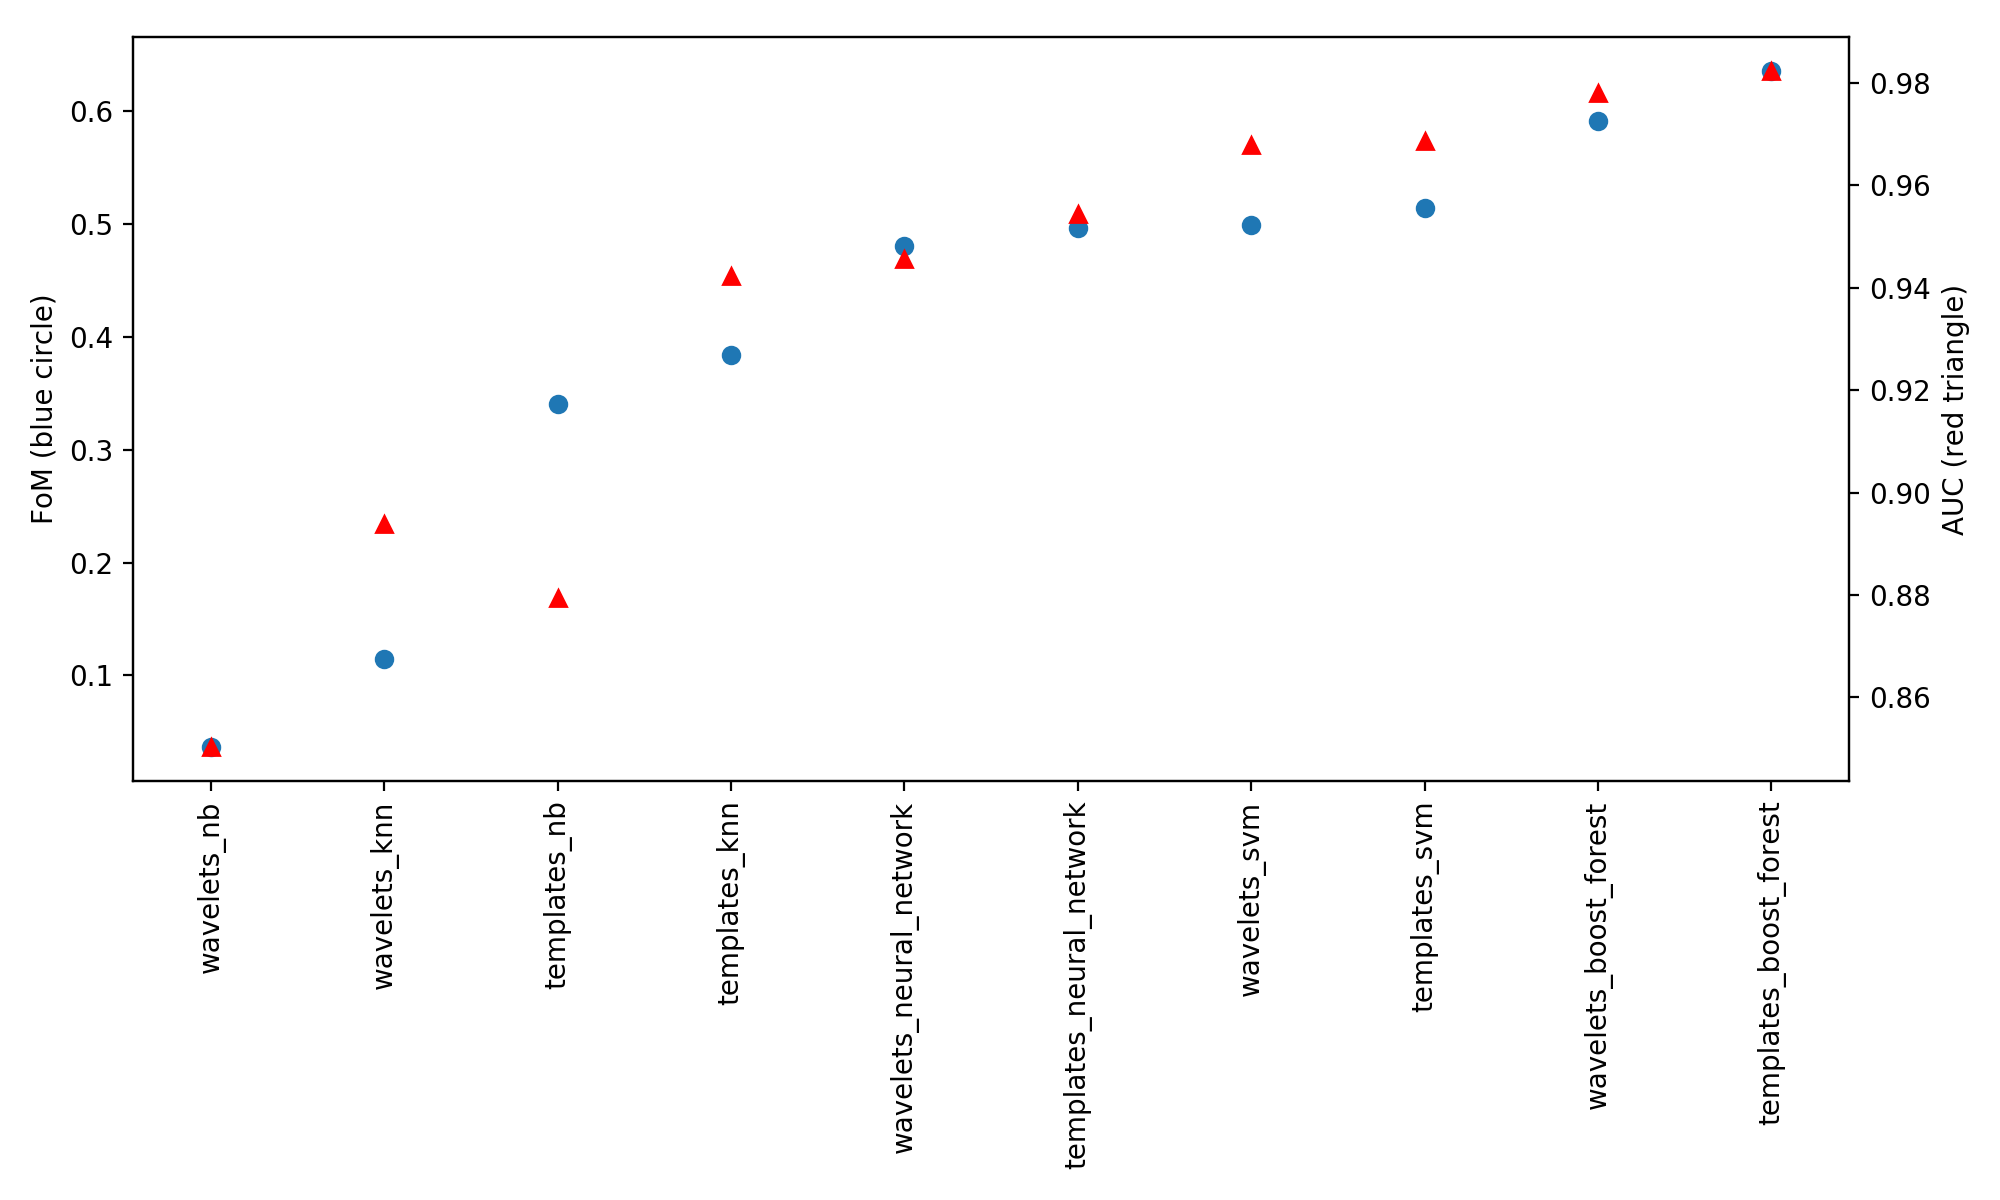

In [187]:
fig = plt.figure(figsize=(10,6))
plt.plot(range(len(results)), results.FoM, 'o')
plt.xticks(range(len(results)), results.index, rotation=90);
plt.ylabel('FoM (blue circle)')

ax2 = plt.gca().twinx()
ax2.plot(range(len(results)), results.AUC,'^r')
plt.ylabel('AUC (red triangle)')

plt.tight_layout()

fig.savefig('fom_vs_auc.png')

<IPython.core.display.Javascript object>


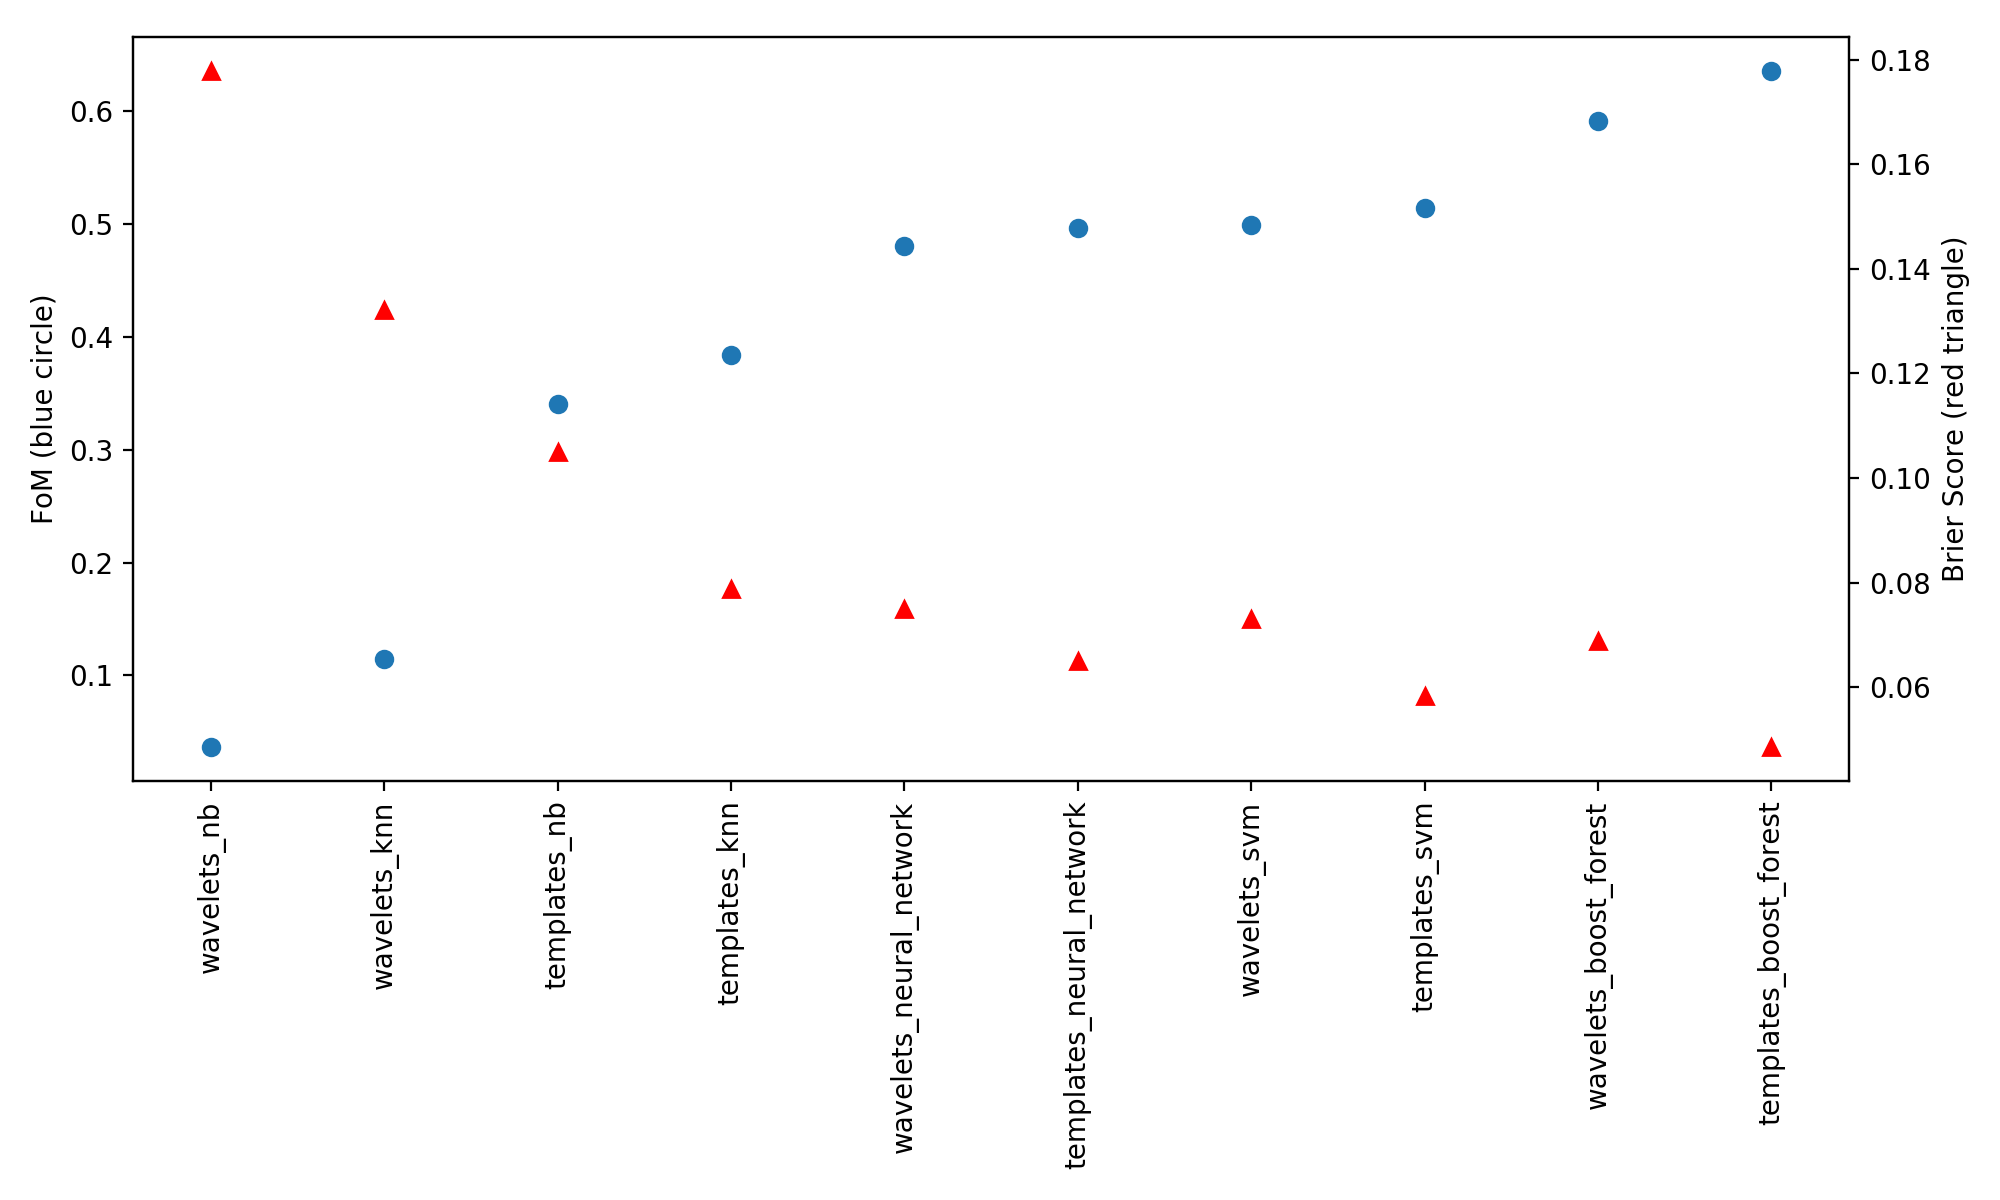

In [188]:
fig = plt.figure(figsize=(10,6))
plt.plot(range(len(results)), results.FoM, 'o')
plt.xticks(range(len(results)), results.index, rotation=90);
plt.ylabel('FoM (blue circle)')

ax2 = plt.gca().twinx()
ax2.plot(range(len(results)), results.Brier,'^r')
plt.ylabel('Brier Score (red triangle)')

plt.tight_layout()
fig.savefig('fom_vs_brier.png')

<IPython.core.display.Javascript object>


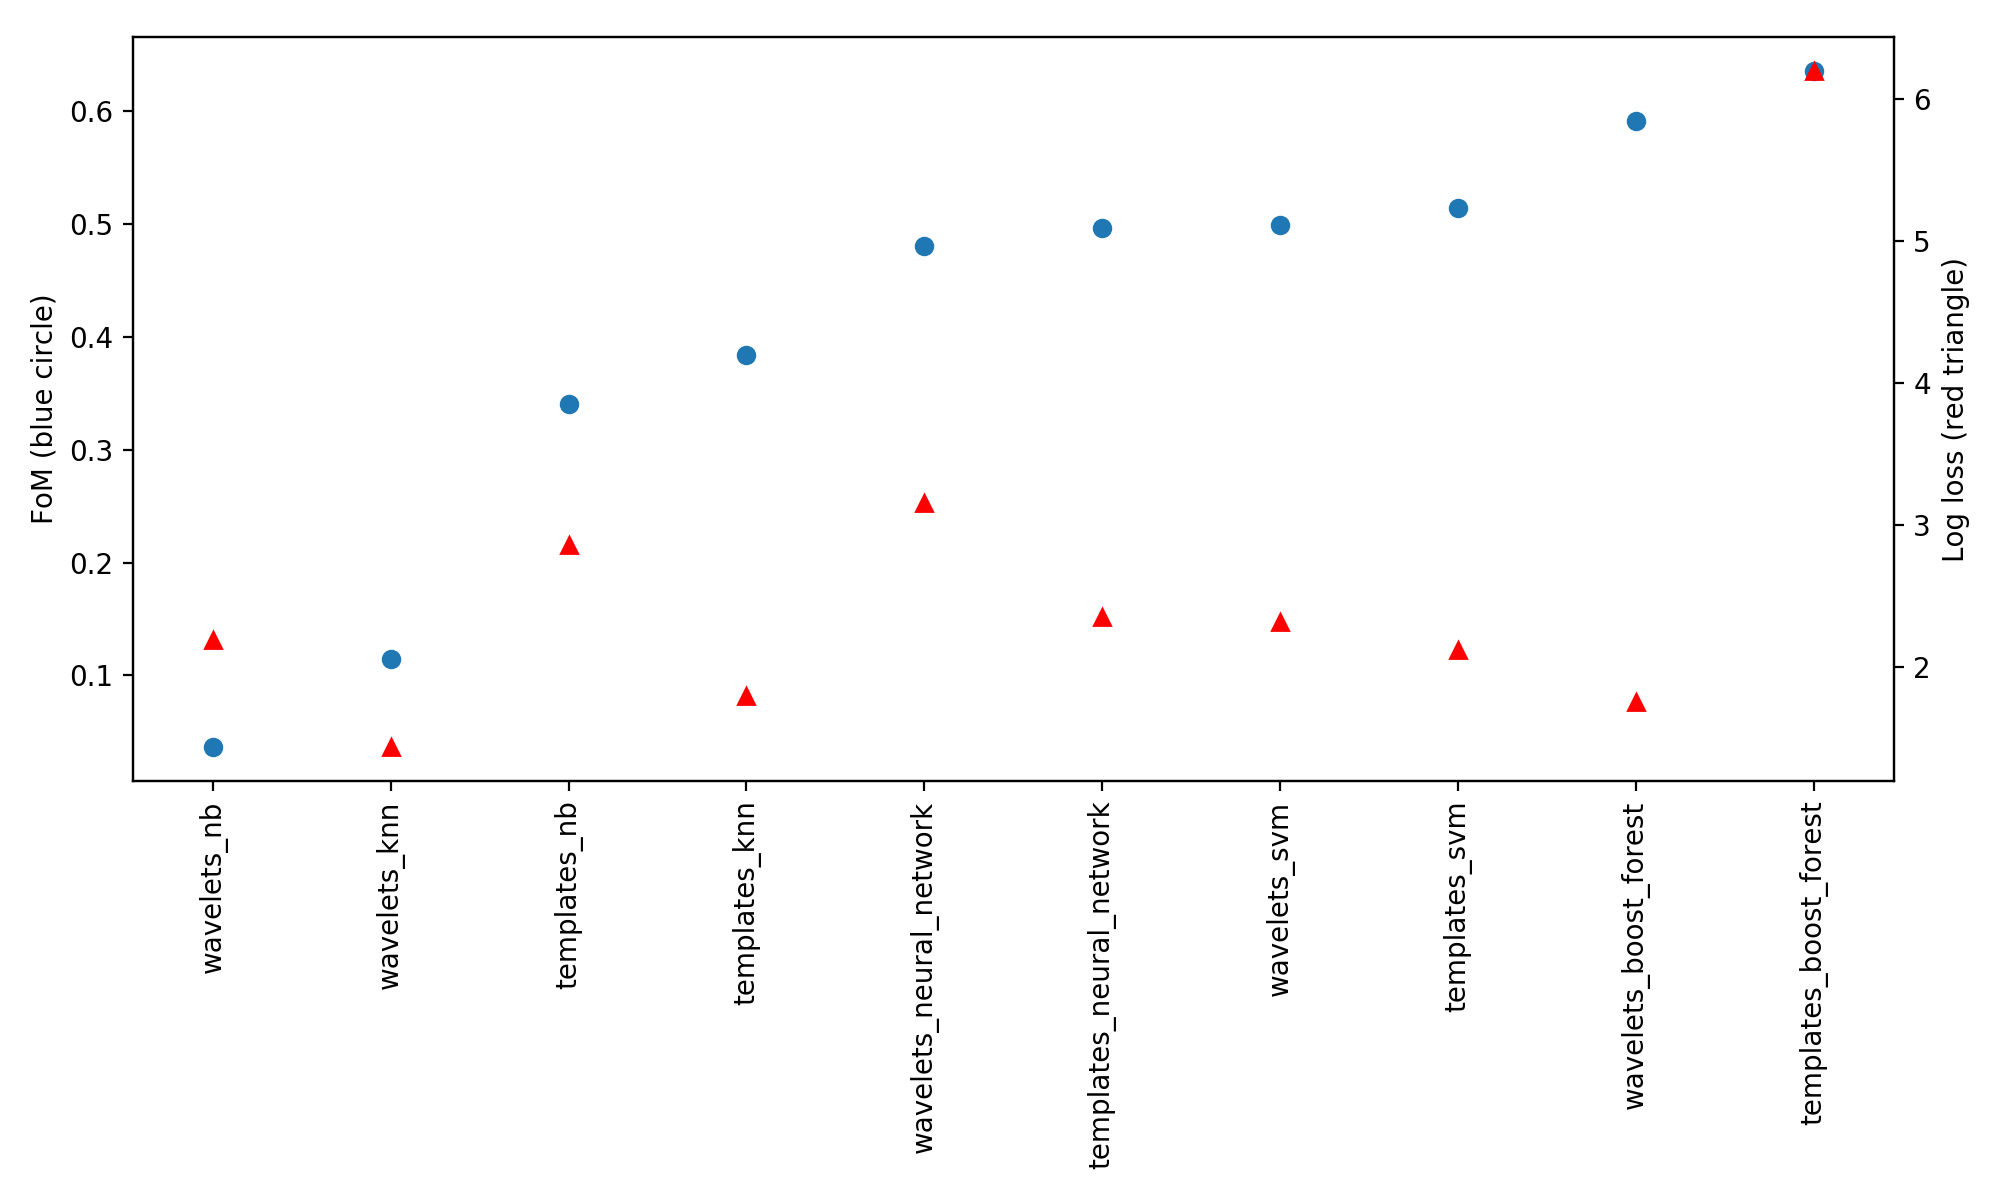

In [189]:
fig =plt.figure(figsize=(10,6))
plt.plot(range(len(results)), results.FoM, 'o')
plt.xticks(range(len(results)), results.index, rotation=90);
plt.ylabel('FoM (blue circle)')

ax2 = plt.gca().twinx()
ax2.plot(range(len(results)), results.Logloss,'^r')
plt.ylabel('Log loss (red triangle)')

plt.tight_layout()
fig.savefig('fom_vs_logloss.png')